# Estimating hotspot(s) emission and rotational axis from visibilties. 

Notes:
Inner most stable circular orbit (ISCO), for spin=0 with r_g=2 this is at 3M \
Overleaf notes: https://www.overleaf.com/project/60ff0ece5aa4f90d07f2a417

In [1]:
import sys
sys.path.append('../bhnerf')

import os

import jax
from jax import random
from jax import numpy as jnp
import jax.scipy.ndimage as jnd
import scipy.ndimage as nd

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import xarray as xr
import flax
from flax.training import train_state
from flax.training import checkpoints
import optax
import numpy as np
import matplotlib.pyplot as plt

import utils, emission_utils, visualization, network_utils, observation_utils
from network_utils import shard

import ehtim as eh
import ehtim.const_def as ehc
from tensorboardX import SummaryWriter
from datetime import datetime
from tqdm.notebook import tqdm
import ipyvolume as ipv
from ipywidgets import interact
import ipywidgets as widgets

# from jax.config import config
# config.update("jax_debug_nans", True)
%load_ext autoreload
%autoreload 2

2021-11-03 15:35:03.342122: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-5_3y1me_ because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Welcome to eht-imaging! v 1.2.2 



# Hotspot Emission Options (only run one of the three cells below)

In [2]:
# Generate hotspot emission (1 hotspot)
nt, nx, ny, nz = 128, 64, 64, 64
nt_test = 128
nspots = 1
r_isco = 3.0 

phi = 0.0            # azimuth angle (ccw from x-axis)
theta = np.pi/3      # zenith angle (pi/2 = equatorial plane)
orbit_radius = 3.5 
std = .4 * np.ones_like(orbit_radius)
initial_frame = emission_utils.generate_hotspots_3d(nx, ny, nz, theta, phi, orbit_radius, std, r_isco, std_clip=np.inf)
rot_axis = np.array([np.cos(theta)*np.cos(phi), np.cos(theta)*np.sin(phi), -np.sin(theta)])

orbit_period = 3.5**(-3./2.) 
velocity_field = lambda r: (1.0 / orbit_period) * r**(-3/2)

emission = emission_utils.generate_orbit_3d(initial_frame, nt, velocity_field, rot_axis)
emission_test = emission_utils.generate_orbit_3d(initial_frame, nt_test, velocity_field, rot_axis)

normalization_factor = 1.0
emission *= normalization_factor
emission_test *= normalization_factor

print('rotation axis: {}'.format(rot_axis))
print('max emission:', np.amax(emission))

rotation axis: [ 0.5        0.        -0.8660254]


In [2]:
# Generate hotspot emission (4 hotspots)
nt, nx, ny, nz = 128, 64, 64, 64
nt_test = 128
nspots = 1
r_isco = 3.0 

phi = 0.0            # azimuth angle (ccw from x-axis)
theta = np.pi/3      # zenith angle (pi/2 = equatorial plane)
orbit_radius = 3.5 
std = .4 * np.ones_like(orbit_radius)
initial_frame = emission_utils.generate_hotspots_3d(nx, ny, nz, theta, phi, orbit_radius, std, r_isco, std_clip=np.inf)
rot_axis = np.array([np.cos(theta)*np.cos(phi), np.cos(theta)*np.sin(phi), -np.sin(theta)])

nspots = 4
frame_subset_inds = [60, 75, 105, 0]  # Generated by np.random.choice(range(0, nt, 5), size=nspots) with np.random.seed(0)
initial_frame = emission_utils.generate_orbit_3d(initial_frame, nt, 1, rot_axis).isel(
    t=frame_subset_inds).sum('t')

orbit_period = 3.5**(-3./2.) 
velocity_field = lambda r: (1.0 / orbit_period) * r**(-3/2)

emission = emission_utils.generate_orbit_3d(initial_frame, nt, velocity_field, rot_axis)
emission_test = emission_utils.generate_orbit_3d(initial_frame, nt_test, velocity_field, rot_axis)

normalization_factor = 1.0
emission *= normalization_factor
emission_test *= normalization_factor

print('rotation axis: {}'.format(rot_axis))
print('max emission:', np.amax(emission))

rotation axis: [ 0.5        0.        -0.8660254]
max emission: <xarray.DataArray ()>
array(1.00000001)


In [25]:
# Generate hotspot emission (fancy, 4 sheared + 4 new hotspots)
nt, nx, ny, nz = 128, 64, 64, 64
nt_test = 128
r_isco = 3.0 

phi = 0.0            # azimuth angle (ccw from x-axis)
theta = np.pi/3      # zenith angle (pi/2 = equatorial plane)
orbit_radius = 3.5 
std = .4 * np.ones_like(orbit_radius)
initial_frame_single = emission_utils.generate_hotspots_3d(nx, ny, nz, theta, phi, orbit_radius, std, r_isco, std_clip=np.inf)
rot_axis = np.array([np.cos(theta)*np.cos(phi), np.cos(theta)*np.sin(phi), -np.sin(theta)])

nspots = 4
frame_subset_inds = [60, 75, 105, 0]  # Generated by np.random.choice(range(0, 128, 5), size=nspots) with np.random.seed(0)
# Sum over rotated positions of n_spots
initial_frame_nspots = emission_utils.generate_orbit_3d(initial_frame_single, nt, 1, rot_axis).isel(
    t=frame_subset_inds).sum('t')

orbit_period = 3.5**(-3./2.) 
velocity_field = lambda r: (1.0 / orbit_period) * r**(-3/2)

# Shear initial hotspots
emission_sheared = emission_utils.generate_orbit_3d(initial_frame_nspots, nt, velocity_field, rot_axis)

# Select base frame from sheared hotspots
base_timestep = nt // 4
initial_frame_sheared = emission_sheared.isel(t=base_timestep)

# Generate new rotated hotspots
nspots_new = 4
frame_subset_inds_new = [25, 55, 60, 40]  # Generated by np.random.choice(range(0, 128, 5), size=nspots_new) with np.random.seed(1)
# Sum over rotated positions of n_spots
initial_frame_new = emission_utils.generate_orbit_3d(initial_frame_single, nt, 1, rot_axis).isel(
    t=frame_subset_inds_new).sum('t')

# Add fancy base frame
initial_frame_fancy = initial_frame_new + initial_frame_sheared

# Shear fancy emission
emission = emission_utils.generate_orbit_3d(initial_frame_fancy, nt, velocity_field, rot_axis)
emission_test = emission_utils.generate_orbit_3d(initial_frame_fancy, nt_test, velocity_field, rot_axis)

normalization_factor = 1.0
emission *= normalization_factor
emission_test *= normalization_factor

print('rotation axis: {}'.format(rot_axis))
print('max emission:', np.amax(emission))

rotation axis: [ 0.5        0.        -0.8660254]
max emission: <xarray.DataArray ()>
array(1.20718223)


In [29]:
print(10. * np.log10(1.**2/2.5822e-4))
print(10. * np.log10(1.**2/3.2136e-3))
print(10. * np.log10(1.20718223**2/3.2455e-3))

35.88010123211141
24.930081812763852
26.522640543327615


In [3]:
extent = [(float(emission[dim].min()), float(emission[dim].max())) for dim in ('x', 'y', 'z')]
@interact(t=widgets.IntSlider(min=0, max=emission.t.size-1, step=1, value=0))
def plot_vol(t):
    ipv.figure()
    ipv.view(0, -60, distance=2.5)
    ipv.volshow(emission.isel(t=t), extent=extent, memorder='F', level=[0, 0.2, 0.7], opacity=[0, 0.2, 0.3], controls=False)
    ipv.show()

interactive(children=(IntSlider(value=0, description='t', max=127), Output()), _dom_classes=('widget-interact'…

In [4]:
# Generate image plane fluxes
sensor = xr.load_dataset('../sensors/a0.00_th1.57_ngeo100_npix4096.nc')
sensor = sensor.where(sensor.r < 5)
r_min = sensor.r.min().data   # Minimum supervision radius
r_max = sensor.r.max().data
sensor = sensor.fillna(0.0)

image_plane = emission_utils.integrate_rays(emission, sensor).data.reshape(nt, sensor.num_alpha, sensor.num_beta)
image_plane_test = emission_utils.integrate_rays(emission_test, sensor).data.reshape(nt_test, sensor.num_alpha, sensor.num_beta)

# Training for Grid Model

In [35]:
def intensity_to_nchw(intensity, cmap='viridis', gamma=0.5):
    cm = plt.get_cmap(cmap)
    minval = np.amin(intensity)
    maxval = np.amax(intensity)
    norm_images = ( (intensity - minval) / (maxval - minval) )**gamma
    nchw_images = np.moveaxis(cm(norm_images)[...,:3], (0, 1, 2, 3), (3, 2, 0, 1))
    return nchw_images

def train_grid(sensor, emission, emission_test, velocity_field, hparams, runname, 
                  log_period=100, save_period=10000, x_res_vis=64, y_res_vis=64, z_res_vis=64):
    
    # Training / testing coordinates
    train_coords = network_utils.get_input_coords(sensor, t_array=np.linspace(0., 1., emission.t.size), batch='t')
    t, x, y, z, d = train_coords.values()

    test_coords = network_utils.get_input_coords(sensor, t_array=np.linspace(0., 1., emission.t.size), batch='t')
    t_test, x_test, y_test, z_test, d_test = test_coords.values()

    # Emission visualization inputs
    t_res_vis = 1
    emission_extent = [emission.x[0], emission.x[-1], emission.y[0], emission.y[-1], emission.z[0], emission.z[-1]]
    t_vis, x_vis, y_vis, z_vis  = np.meshgrid(0.0, np.linspace(emission_extent[0], emission_extent[1], x_res_vis),
                                              np.linspace(emission_extent[2], emission_extent[3], y_res_vis),
                                              np.linspace(emission_extent[4], emission_extent[5], x_res_vis),
                                              indexing='ij')

    d_vis = np.ones_like(y_vis)                  # meaningless placeholder for emission visualization
    target_vis = np.ones([y_res_vis, x_res_vis]) # meaningless placeholder for emission visualization
    r_min = hparams['r_min']                 # Zero network output where there is no supervision (within black-hole radius)  
    r_max = hparams['r_max']
        
    # Model setup and initialization
    rng = jax.random.PRNGKey(1)
    predictor = network_utils.PREDICT_EMISSION_3D_GRID()
    params = predictor.init(rng, x[:1, ...], y[:1, ...], z[:1, ...], t[:1, ...], velocity_field, rot_axis)['params']
    tx = optax.adam(learning_rate=optax.polynomial_schedule(hparams['lr_init'], hparams['lr_final'], 1, hparams['num_iters']))
    state = train_state.TrainState.create(apply_fn=predictor.apply, params=params.unfreeze(), tx=tx)  # TODO(pratul): this unfreeze feels sketchy
    
    if np.isscalar(save_period):
        checkpoint_dir = 'checkpoints/{}'.format(runname)
        state = checkpoints.restore_checkpoint(checkpoint_dir, state)
    init_step = 1 + state.step

    train_pstep = jax.pmap(predictor.train_step, axis_name='batch', in_axes=(None, None, None, 0, 0, 0, 0, 0, 0, 0, 0), static_broadcasted_argnums=(0))
    eval_pstep = jax.pmap(predictor.eval_step, axis_name='batch', in_axes=(None, None, None, 0, 0, 0, 0, 0, 0, 0, 0), static_broadcasted_argnums=(0))
    rand_key = jax.random.split(rng, jax.local_device_count())
    state = flax.jax_utils.replicate(state)


    # TensorBoard logging
    time = datetime.now().strftime('%Y-%m-%d.%H:%M:%S')
    logdir = 'runs/{}.{}'.format(runname, time)
    with SummaryWriter(logdir=logdir) as writer:

        # Log ground-truth data   
        %matplotlib inline
        images_true = intensity_to_nchw(emission.isel(t=0))        

        for i in tqdm(range(1, hparams['num_iters']+1), desc='iteration'):

            # Testing and Visualization
            if (i == 1) or (i % log_period) == 0:

                batch_inds = np.random.randint(0, x.shape[0], hparams['batchsize'])
                loss_test, _, _, rendering_test, _ = eval_pstep(
                    velocity_field, rot_axis, i, 
                    shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
                    shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), shard(image_plane_test[batch_inds, ...]), 
                    state, rand_key
                )
                writer.add_scalar('log loss/test', np.log10(np.mean(float(loss_test))), global_step=i)

                # Log prediction and estimate
                _, _, emission_vis, _, _ = eval_pstep(
                    velocity_field, rot_axis, i, shard(x_vis), shard(y_vis), shard(z_vis), 
                    shard(d_vis), shard(t_vis), shard(target_vis), state, rand_key
                )
                emission_vis = np.reshape(emission_vis, [t_res_vis, x_res_vis, y_res_vis, z_res_vis])
                emission_vis = jnp.where(x_vis**2 + y_vis**2 + z_vis**2 < r_min**2, jnp.zeros_like(emission_vis), emission_vis)
                emission_vis = jnp.where(x_vis**2 + y_vis**2 + z_vis**2 > r_max**2, jnp.zeros_like(emission_vis), emission_vis)
                
                # Log initialization seperately 
                images = intensity_to_nchw(emission_vis[0])
                writer.add_images('emission/estimate', images, global_step=i)
                writer.add_images('emission/true', images_true, global_step=i)
                writer.add_image('rendering/test', rendering_test[0, 0, None, :, :], global_step=i)
                writer.add_image('rendering/true', image_plane_test[batch_inds[0], None, ...], global_step=i)
                writer.add_image('rendering/diff', np.abs(image_plane_test[batch_inds[0], None, ...] - rendering_test[0, 0, None, :, :]), global_step=i)
                
                writer.add_scalar('emission_mse', float(np.mean((emission.data[0] - emission_vis)**2)), global_step=i)
                
            # Training
            batch_inds = np.random.randint(0, x.shape[0], hparams['batchsize'])
            loss_train, state, _, _, rand_key = train_pstep(
                velocity_field, rot_axis, i, 
                shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
                shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), shard(image_plane[batch_inds, ...]), 
                state, rand_key
            )
            writer.add_scalar('log loss/train', np.log10(float(np.mean(loss_train))), global_step=i)
            
            if np.isscalar(save_period) and ((i % save_period == 0) or (i == hparams['num_iters'])):
                state_to_save = jax.device_get(jax.tree_map(lambda x: x[0], state))
                checkpoints.save_checkpoint(checkpoint_dir, state_to_save, int(i), keep=5)
            
    return state, emission_vis

In [36]:
# Training parameters
hparams = {
    'num_iters': 5000,
    'lr_init': 1e-2,
    'lr_final': 1e-4,
    'batchsize': 8,
    'r_min': r_min,
    'r_max': r_max,
}

runname = 'nerf_vs_grid_11_1_21/grid_fancy_4+4_spots'
state, emission_vis = train_grid(
    sensor, emission, emission_test, velocity_field, hparams, 
    runname=runname, log_period=100, save_period=5000, x_res_vis=64, y_res_vis=64, z_res_vis=64
)
# emission_estimate = emission_utils.generate_orbit_3d(
#     xr.DataArray(emission_vis[0], coords=initial_frame.coords), nt, velocity_field, rot_axis)

/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:390: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  warnings.warn(
/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:377: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  warnings.warn(


iteration:   0%|          | 0/5000 [00:00<?, ?it/s]

# Training for Network Model (3D, with velocity)

In [37]:
def intensity_to_nchw(intensity, cmap='viridis', gamma=0.5):
    cm = plt.get_cmap(cmap)
    norm_images = ( (intensity - np.min(intensity)) / (np.max(intensity) - np.min(intensity)) )**gamma
    nchw_images = np.moveaxis(cm(norm_images)[...,:3], (0, 1, 2, 3), (3, 2, 0, 1))
    return nchw_images

def train_network(sensor, emission, emission_test, velocity_field, hparams, runname, 
                  log_period=100, save_period=10000, x_res_vis=64, y_res_vis=64, z_res_vis=64):
    
    # Training / testing coordinates
    train_coords = network_utils.get_input_coords(sensor, t_array=np.linspace(0., 1., emission.t.size), batch='t')
    t, x, y, z, d = train_coords.values()

    test_coords = network_utils.get_input_coords(sensor, t_array=np.linspace(0., 1., emission.t.size), batch='t')
    t_test, x_test, y_test, z_test, d_test = test_coords.values()

    # Emission visualization inputs
    t_res_vis = 1
    emission_extent = [emission.x[0], emission.x[-1], emission.y[0], emission.y[-1], emission.z[0], emission.z[-1]]
    t_vis, x_vis, y_vis, z_vis  = np.meshgrid(0.0, np.linspace(emission_extent[0], emission_extent[1], x_res_vis),
                                              np.linspace(emission_extent[2], emission_extent[3], y_res_vis),
                                              np.linspace(emission_extent[4], emission_extent[5], x_res_vis),
                                              indexing='ij')

    d_vis = np.ones_like(y_vis)                  # meaningless placeholder for emission visualization
    target_vis = np.ones([y_res_vis, x_res_vis]) # meaningless placeholder for emission visualization
    r_min = hparams['r_min']                 # Zero network output where there is no supervision (within black-hole radius)  
    r_max = hparams['r_max']
    
    # Model setup and initialization
    rng = jax.random.PRNGKey(1)
    predictor = network_utils.PREDICT_EMISSION_3D()
    params = predictor.init(rng, x[:1, ...], y[:1, ...], z[:1, ...], t[:1, ...], velocity_field, rot_axis)['params']
    tx = optax.adam(learning_rate=optax.polynomial_schedule(hparams['lr_init'], hparams['lr_final'], 1, hparams['num_iters']))
    state = train_state.TrainState.create(apply_fn=predictor.apply, params=params.unfreeze(), tx=tx)  # TODO(pratul): this unfreeze feels sketchy
    
    if np.isscalar(save_period):
        checkpoint_dir = 'checkpoints/{}'.format(runname)
        state = checkpoints.restore_checkpoint(checkpoint_dir, state)
    init_step = 1 + state.step

    train_pstep = jax.pmap(predictor.train_step, axis_name='batch', in_axes=(None, None, None, 0, 0, 0, 0, 0, 0, 0, 0), static_broadcasted_argnums=(0))
    eval_pstep = jax.pmap(predictor.eval_step, axis_name='batch', in_axes=(None, None, None, 0, 0, 0, 0, 0, 0, 0, 0), static_broadcasted_argnums=(0))
    rand_key = jax.random.split(rng, jax.local_device_count())
    state = flax.jax_utils.replicate(state)


    # TensorBoard logging
    time = datetime.now().strftime('%Y-%m-%d.%H:%M:%S')
    logdir = 'runs/{}.{}'.format(runname, time)
    with SummaryWriter(logdir=logdir) as writer:

        # Log ground-truth data   
        %matplotlib inline
        images_true = intensity_to_nchw(emission.isel(t=0))        

        for i in tqdm(range(1, hparams['num_iters']+1), desc='iteration'):

            # Testing and Visualization
            if (i == 1) or (i % log_period) == 0:

                batch_inds = np.random.randint(0, x.shape[0], hparams['batchsize'])
                loss_test, _, _, rendering_test, _ = eval_pstep(
                    velocity_field, rot_axis, i, 
                    shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
                    shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), shard(image_plane_test[batch_inds, ...]), 
                    state, rand_key
                )
                writer.add_scalar('log loss/test', np.log10(np.mean(float(loss_test))), global_step=i)

                # Log prediction and estimate
                _, _, emission_vis, _, _ = eval_pstep(
                    velocity_field, rot_axis, i, shard(x_vis), shard(y_vis), shard(z_vis), 
                    shard(d_vis), shard(t_vis), shard(target_vis), state, rand_key
                )
                emission_vis = np.reshape(emission_vis, [t_res_vis, x_res_vis, y_res_vis, z_res_vis])
                emission_vis = jnp.where(x_vis**2 + y_vis**2 + z_vis**2 < r_min**2, jnp.zeros_like(emission_vis), emission_vis)
                emission_vis = jnp.where(x_vis**2 + y_vis**2 + z_vis**2 > r_max**2, jnp.zeros_like(emission_vis), emission_vis)
                
                # Log initialization seperately 
                images = intensity_to_nchw(emission_vis[0])
                writer.add_images('emission/estimate', images, global_step=i)
                writer.add_images('emission/true', images_true, global_step=i)
                writer.add_image('rendering/test', rendering_test[0, 0, None, :, :], global_step=i)
                writer.add_image('rendering/true', image_plane_test[batch_inds[0], None, ...], global_step=i)
                writer.add_image('rendering/diff', np.abs(image_plane_test[batch_inds[0], None, ...] - rendering_test[0, 0, None, :, :]), global_step=i)
                
                writer.add_scalar('emission_mse', float(np.mean((emission.data[0] - emission_vis)**2)), global_step=i)
                
            # Training
            batch_inds = np.random.randint(0, x.shape[0], hparams['batchsize'])
            loss_train, state, _, _, rand_key = train_pstep(
                velocity_field, rot_axis, i, 
                shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
                shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), shard(image_plane[batch_inds, ...]), 
                state, rand_key
            )
            writer.add_scalar('log loss/train', np.log10(float(np.mean(loss_train))), global_step=i)
            
            if np.isscalar(save_period) and ((i % save_period == 0) or (i == hparams['num_iters'])):
                state_to_save = jax.device_get(jax.tree_map(lambda x: x[0], state))
                checkpoints.save_checkpoint(checkpoint_dir, state_to_save, int(i), keep=5)
            
    return state, emission_vis

In [38]:
# Training parameters
hparams = {
    'num_iters': 5000,
    'lr_init': 1e-4,
    'lr_final': 1e-6,
    'lr_axis': 1e-2,
    'posenc_deg': 3,
    'batchsize': 8,
    'r_min': r_min,
    'r_max': r_max,
}
# runname = '{}/known_riaf.flux{}.norm{}.rot_axis_MLP.fov{}.batch{}.phi{:2.1f}.theta{:2.1f}.nspots{}.nonoise'.format(
#     array_name, riaf_flux, normalization_factor, fov, hparams['batchsize'], np.rad2deg(phi), np.rad2deg(theta), nspots
# )

runname = 'nerf_vs_grid_11_1_21/network_fancy_4+4_spots'
state, emission_vis = train_network(
    sensor, emission, emission_test, velocity_field, hparams, 
    runname=runname, log_period=100, save_period=5000, x_res_vis=64, y_res_vis=64, z_res_vis=64
)
# emission_estimate = emission_utils.generate_orbit_3d(
#     xr.DataArray(emission_vis[0], coords=initial_frame.coords), nt, velocity_field, rot_axis_est)

/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:390: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  warnings.warn(
/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:377: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  warnings.warn(


iteration:   0%|          | 0/5000 [00:00<?, ?it/s]

# Training for Network Model (4D, without velocity)

In [5]:
def intensity_to_nchw(intensity, cmap='viridis', gamma=0.5):
    cm = plt.get_cmap(cmap)
    norm_images = ( (intensity - np.min(intensity)) / (np.max(intensity) - np.min(intensity)) )**gamma
    nchw_images = np.moveaxis(cm(norm_images)[...,:3], (0, 1, 2, 3), (3, 2, 0, 1))
    return nchw_images

def train_network(sensor, emission, emission_test, velocity_field, hparams, runname, 
                  log_period=100, save_period=10000, x_res_vis=64, y_res_vis=64, z_res_vis=64):
    
    # Training / testing coordinates
    train_coords = network_utils.get_input_coords(sensor, t_array=np.linspace(0., 1., emission.t.size), batch='t')
    t, x, y, z, d = train_coords.values()

    test_coords = network_utils.get_input_coords(sensor, t_array=np.linspace(0., 1., emission.t.size), batch='t')
    t_test, x_test, y_test, z_test, d_test = test_coords.values()

    # Emission visualization inputs
    t_res_vis = 1
    emission_extent = [emission.x[0], emission.x[-1], emission.y[0], emission.y[-1], emission.z[0], emission.z[-1]]
    t_vis, x_vis, y_vis, z_vis  = np.meshgrid(0.0, np.linspace(emission_extent[0], emission_extent[1], x_res_vis),
                                              np.linspace(emission_extent[2], emission_extent[3], y_res_vis),
                                              np.linspace(emission_extent[4], emission_extent[5], x_res_vis),
                                              indexing='ij')

    d_vis = np.ones_like(y_vis)                  # meaningless placeholder for emission visualization
    target_vis = np.ones([y_res_vis, x_res_vis]) # meaningless placeholder for emission visualization
    r_min = hparams['r_min']                 # Zero network output where there is no supervision (within black-hole radius)  
    r_max = hparams['r_max']
    
    # Model setup and initialization
    rng = jax.random.PRNGKey(1)
    predictor = network_utils.PREDICT_EMISSION_3D_NO_VELOCITY()
    params = predictor.init(rng, x[:1, ...], y[:1, ...], z[:1, ...], t[:1, ...], velocity_field, rot_axis)['params']
    tx = optax.adam(learning_rate=optax.polynomial_schedule(hparams['lr_init'], hparams['lr_final'], 1, hparams['num_iters']))
    state = train_state.TrainState.create(apply_fn=predictor.apply, params=params.unfreeze(), tx=tx)  # TODO(pratul): this unfreeze feels sketchy
    
    if np.isscalar(save_period):
        checkpoint_dir = 'checkpoints/{}'.format(runname)
        state = checkpoints.restore_checkpoint(checkpoint_dir, state)
    init_step = 1 + state.step

    train_pstep = jax.pmap(predictor.train_step, axis_name='batch', in_axes=(None, None, None, 0, 0, 0, 0, 0, 0, 0, 0), static_broadcasted_argnums=(0))
    eval_pstep = jax.pmap(predictor.eval_step, axis_name='batch', in_axes=(None, None, None, 0, 0, 0, 0, 0, 0, 0, 0), static_broadcasted_argnums=(0))
    rand_key = jax.random.split(rng, jax.local_device_count())
    state = flax.jax_utils.replicate(state)


    # TensorBoard logging
    time = datetime.now().strftime('%Y-%m-%d.%H:%M:%S')
    logdir = 'runs/{}.{}'.format(runname, time)
    with SummaryWriter(logdir=logdir) as writer:

        # Log ground-truth data   
        %matplotlib inline
        images_true = intensity_to_nchw(emission.isel(t=0))        

        for i in tqdm(range(1, hparams['num_iters']+1), desc='iteration'):

            # Testing and Visualization
            if (i == 1) or (i % log_period) == 0:

                batch_inds = np.random.randint(0, x.shape[0], hparams['batchsize'])
                loss_test, _, _, rendering_test, _ = eval_pstep(
                    velocity_field, rot_axis, i, 
                    shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
                    shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), shard(image_plane_test[batch_inds, ...]), 
                    state, rand_key
                )
                writer.add_scalar('log loss/test', np.log10(np.mean(float(loss_test))), global_step=i)

                # Log prediction and estimate
                _, _, emission_vis, _, _ = eval_pstep(
                    velocity_field, rot_axis, i, shard(x_vis), shard(y_vis), shard(z_vis), 
                    shard(d_vis), shard(t_vis), shard(target_vis), state, rand_key
                )
                emission_vis = np.reshape(emission_vis, [t_res_vis, x_res_vis, y_res_vis, z_res_vis])
                emission_vis = jnp.where(x_vis**2 + y_vis**2 + z_vis**2 < r_min**2, jnp.zeros_like(emission_vis), emission_vis)
                emission_vis = jnp.where(x_vis**2 + y_vis**2 + z_vis**2 > r_max**2, jnp.zeros_like(emission_vis), emission_vis)
                
                # Log initialization seperately 
                images = intensity_to_nchw(emission_vis[0])
                writer.add_images('emission/estimate', images, global_step=i)
                writer.add_images('emission/true', images_true, global_step=i)
                writer.add_image('rendering/test', rendering_test[0, 0, None, :, :], global_step=i)
                writer.add_image('rendering/true', image_plane_test[batch_inds[0], None, ...], global_step=i)
                writer.add_image('rendering/diff', np.abs(image_plane_test[batch_inds[0], None, ...] - rendering_test[0, 0, None, :, :]), global_step=i)
                
                writer.add_scalar('emission_mse', float(np.mean((emission.data[0] - emission_vis)**2)), global_step=i)
                
            # Training
            batch_inds = np.random.randint(0, x.shape[0], hparams['batchsize'])
            loss_train, state, _, _, rand_key = train_pstep(
                velocity_field, rot_axis, i, 
                shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
                shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), shard(image_plane[batch_inds, ...]), 
                state, rand_key
            )
            writer.add_scalar('log loss/train', np.log10(float(np.mean(loss_train))), global_step=i)
            
            if np.isscalar(save_period) and ((i % save_period == 0) or (i == hparams['num_iters'])):
                state_to_save = jax.device_get(jax.tree_map(lambda x: x[0], state))
                checkpoints.save_checkpoint(checkpoint_dir, state_to_save, int(i), keep=5)
            
    return state, emission_vis

In [6]:
# Training parameters
hparams = {
    'num_iters': 5000,
    'lr_init': 1e-4,
    'lr_final': 1e-6,
    'lr_axis': 1e-2,
    'posenc_deg': 3,
    'batchsize': 8,
    'r_min': r_min,
    'r_max': r_max,
}
# runname = '{}/known_riaf.flux{}.norm{}.rot_axis_MLP.fov{}.batch{}.phi{:2.1f}.theta{:2.1f}.nspots{}.nonoise'.format(
#     array_name, riaf_flux, normalization_factor, fov, hparams['batchsize'], np.rad2deg(phi), np.rad2deg(theta), nspots
# )

runname = 'nerf_vs_grid_11_3_21/network_4D_fancy_4+4_spots'
state, emission_vis = train_network(
    sensor, emission, emission_test, velocity_field, hparams, 
    runname=runname, log_period=100, save_period=5000, x_res_vis=64, y_res_vis=64, z_res_vis=64
)
# emission_estimate = emission_utils.generate_orbit_3d(
#     xr.DataArray(emission_vis[0], coords=initial_frame.coords), nt, velocity_field, rot_axis_est)

/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:390: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  warnings.warn(
/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:377: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  warnings.warn(


iteration:   0%|          | 0/5000 [00:00<?, ?it/s]

In [5]:
# Volume rendering functions

def normalize(x):
    """Normalization helper function."""
    return x / np.linalg.norm(x)

def viewmatrix(lookdir, up, position):
    """Construct lookat view matrix."""
    vec2 = normalize(lookdir)
    vec0 = normalize(np.cross(up, vec2))
    vec1 = normalize(np.cross(vec2, vec0))
    m = np.stack([vec0, vec1, vec2, position], axis=1)
    return m

def generate_hemispherical_orbit(radius, n_frames=120):
    """Calculates a render path which orbits around the z-axis."""
    # Assume that z-axis points up towards approximate camera hemisphere
    render_poses = []

    up = np.array([0., 0., 1.])
    for theta in np.linspace(0., 2. * np.pi, n_frames):
        camorigin = radius * np.array(
            [np.cos(theta), np.sin(theta), 0.])
        render_poses.append(viewmatrix(camorigin, up, camorigin))

    render_poses = np.stack(render_poses, axis=0)
    return render_poses

def generate_elevated_orbit(radius, height, n_frames=120):
    """Calculates a render path which orbits around the z-axis."""
    # Assume that z-axis points up towards approximate camera hemisphere
    render_poses = []
    
    orbit_radius = np.sqrt(radius**2 - height**2)

    up = np.array([0., 0., 1.])
    for theta in np.linspace(0., 2. * np.pi, n_frames):
        camorigin = np.array(
            [orbit_radius * np.cos(theta), orbit_radius * np.sin(theta), height])
        render_poses.append(viewmatrix(camorigin, up, camorigin))

    render_poses = np.stack(render_poses, axis=0)
    return render_poses

def generate_rays(camtoworlds, width, height, focal):
    """Generating rays for all images."""
    x, y = np.meshgrid(  # pylint: disable=unbalanced-tuple-unpacking
        np.arange(width, dtype=np.float32),  # X-Axis (columns)
        np.arange(height, dtype=np.float32),  # Y-Axis (rows)
        indexing='xy')
    camera_dirs = np.stack(
        [(x - width * 0.5 + 0.5) / focal,
         -(y - height * 0.5 + 0.5) / focal, -np.ones_like(x)],
        axis=-1)
    directions = ((camera_dirs[None, ..., None, :] *
                   camtoworlds[:, None, None, :3, :3]).sum(axis=-1))
    origins = np.broadcast_to(camtoworlds[:, None, None, :3, -1],
                              directions.shape)

    return origins, directions

def sample_along_rays(rays_o, rays_d, near, far, num_samples):
    t_vals = jnp.linspace(near, far, num_samples)
    pts = rays_o[:, :, :, None, :] + t_vals[None, None, None, :, None] * rays_d[:, :, :, None, :]
    return pts

def draw_cube(emission_cm, pts):
    facewidth = 10.
    linewidth = 0.1
#     linecolor = jnp.array([1000.0, 1000.0, 1000.0])
    linecolor = jnp.array([0.0, 0.0, 0.0, 1000.0])
    vertices = jnp.array([[-facewidth/2., -facewidth/2., -facewidth/2.],
                        [facewidth/2., -facewidth/2., -facewidth/2.],
                        [-facewidth/2., facewidth/2., -facewidth/2.],
                        [facewidth/2., facewidth/2., -facewidth/2.],
                        [-facewidth/2., -facewidth/2., facewidth/2.],
                        [facewidth/2., -facewidth/2., facewidth/2.],
                        [-facewidth/2., facewidth/2., facewidth/2.],
                        [facewidth/2., facewidth/2., facewidth/2.]])
    dirs = jnp.array([[-1., 0., 0.],
                      [1., 0., 0.],
                      [0., -1., 0.],
                      [0., 1., 0.],
                      [0., 0., -1.],
                      [0., 0., 1.]])
        
#     emission = jnp.where(jnp.less(jnp.broadcast_to(emission[..., 0, None], emission.shape), 0.1), 
#                          jnp.zeros_like(emission), emission)

    for i in range(vertices.shape[0]):

        for j in range(dirs.shape[0]):
            # Draw line segments from each vertex
            line_seg_pts = vertices[i, None, :] + jnp.linspace(0.0, facewidth, 64)[:, None] * dirs[j, None, :]

            for k in range(line_seg_pts.shape[0]):
                dists = jnp.linalg.norm(pts - jnp.broadcast_to(line_seg_pts[k, None, None, None, :], pts.shape), axis=-1)
                # out = jnp.where(jnp.less_equal(dists, linewidth),
                #                 lineval * jnp.exp(-1. * dists), out)
                emission_cm += linecolor[None, None, None, :] * jnp.exp(-1. * dists / linewidth ** 2)[..., None]
    
    out = jnp.where(jnp.greater(jnp.broadcast_to(jnp.amax(jnp.abs(pts), axis=-1, keepdims=True), 
                                                 emission_cm.shape), 
                                facewidth/2. + linewidth), 
                    jnp.zeros_like(emission_cm), emission_cm)
        
    return out

def alpha_composite(emission, dists, pts, inside_halfwidth=4.5):
    emission = np.clip(emission, 0., 1.)
    color = emission[..., :-1] * dists[0, ..., None]
    alpha = emission[..., -1:] 
    
    inside = np.where(np.less(np.amax(np.abs(pts), axis=-1), inside_halfwidth), 
                      np.ones_like(pts[..., 0]),
                      np.zeros_like(pts[..., 0]))
    
    rendering = np.zeros_like(color[:, :, 0, :])
    acc = np.zeros_like(color[:, :, 0, 0])
    outside_acc = np.zeros_like(color[:, :, 0, 0])
    for i in range(alpha.shape[-2]):
        ind = alpha.shape[-2] - i - 1
        
        # if pixels inside cube, don't alpha composite
        rendering = rendering + inside[..., ind, None] * color[..., ind, :]
        
        # if pixels not inside cube, alpha composite      
        outside_alpha = alpha[..., ind, :] * (1. - inside[..., ind, None])
        rendering = rendering * (1. - outside_alpha) + color[..., ind, :] * outside_alpha 
        
        acc = alpha[..., ind, 0] + (1. - alpha[..., ind, 0]) * acc
        outside_acc = outside_alpha[..., 0] + (1. - outside_alpha[..., 0]) * outside_acc
        
    rendering += np.array([1., 1., 1.])[None, None, :] * (1. - acc[..., None])
    return rendering, outside_acc

In [6]:
# Visualize Ground Truth

x_res_vis = 256
y_res_vis = 256
z_res_vis = 256

# x_res_vis = 128
# y_res_vis = 128
# z_res_vis = 128

poses = generate_elevated_orbit(25., 12.5, n_frames=60)
height = y_res_vis
width = x_res_vis
focal = .5 * width / jnp.tan(.5 * 0.7)
rays_o, rays_d = generate_rays(poses, width, height, focal)

i = 35
t = 0.0

pts = sample_along_rays(rays_o[i:i+1, ...], rays_d[i:i+1, ...], 15., 35., z_res_vis)

x_vis = pts[:, :, :, :, 0]
y_vis = pts[:, :, :, :, 1]
z_vis = pts[:, :, :, :, 2]
d_vis = jnp.linalg.norm(jnp.concatenate([jnp.diff(pts[:, ...], axis=3),
                                         jnp.zeros_like(pts[:, :, :, -1:])], 
                                         axis=3), axis=-1)

emission_gt = emission.sel(t=t, method='nearest').interp(x=xr.DataArray(x_vis[0, ...]),
                                                         y=xr.DataArray(y_vis[0, ...]),
                                                         z=xr.DataArray(z_vis[0, ...])).fillna(0.0).data

cm = plt.get_cmap('hot')
emission_cm = cm(emission_gt)
emission_cm = jnp.clip(emission_cm - 0.05, 0.0, 1.0)
emission_cm = jnp.concatenate([emission_cm[..., :3], (emission_gt[..., None] / jnp.amax(emission_gt))], axis=-1)

emission_vis_cube = draw_cube(emission_cm, jnp.stack([x_vis[0], y_vis[0], z_vis[0]], axis=-1))

# scale for visualization
emission_vis_cube *= 1.

rendering, _ = alpha_composite(emission_vis_cube, d_vis, pts[0, ...])

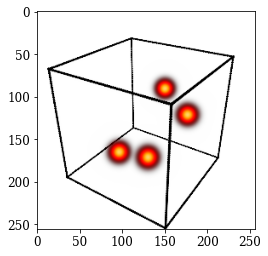

In [7]:
plt.figure()
plt.imshow(np.clip(rendering, 0.0, 1.0))
# plt.imsave('figures/nerf_vs_grid_1_spot_gt.pdf', np.clip(rendering, 0.0, 1.0))
# plt.imsave('figures/nerf_vs_grid_4_spots_gt.pdf', np.clip(rendering, 0.0, 1.0))
# plt.imsave('figures/nerf_vs_grid_4+4_spots_gt.pdf', np.clip(rendering, 0.0, 1.0))

In [7]:
# Visualize Grid Emission

t_vis = t * jnp.ones_like(x_vis)

hparams = {
    'num_iters': 5000,
    'lr_init': 1e-4,
    'lr_final': 1e-6,
    'lr_axis': 1e-2,
    'posenc_deg': 3,
    'batchsize': 8,
    'r_min': r_min,
    'r_max': r_max,
}

# runname = 'nerf_vs_grid_11_1_21/grid_1_spot'
# runname = 'nerf_vs_grid_11_1_21/grid_4_spots'
runname = 'nerf_vs_grid_11_1_21/grid_fancy_4+4_spots'

# Model setup and initialization

rng = jax.random.PRNGKey(1)

predictor = network_utils.PREDICT_EMISSION_3D_GRID()
params = predictor.init(rng, x_vis[0, :1, ...], y_vis[0, :1, ...], z_vis[0, :1, ...], t_vis[0, :1, ...], velocity_field, rot_axis)['params']
tx = optax.adam(learning_rate=optax.polynomial_schedule(hparams['lr_init'], hparams['lr_final'], 1, hparams['num_iters']))
state = train_state.TrainState.create(apply_fn=predictor.apply, params=params.unfreeze(), tx=tx)  # TODO(pratul): this unfreeze feels sketchy

checkpoint_dir = 'checkpoints/{}'.format(runname)
state = checkpoints.restore_checkpoint(checkpoint_dir, state)

eval_pstep = jax.pmap(predictor.eval_step, axis_name='batch', in_axes=(None, None, None, 0, 0, 0, 0, 0, 0, 0, 0), static_broadcasted_argnums=(0))

state = flax.jax_utils.replicate(state)

rand_key = jax.random.split(rng, jax.local_device_count())

_, _, emission_vis, _, _ = eval_pstep(velocity_field, rot_axis, i, shard(x_vis), shard(y_vis), shard(z_vis), 
                                      shard(d_vis), shard(t_vis), shard(jnp.zeros_like(x_vis[..., 0])), state, rand_key)
emission_vis = np.reshape(emission_vis, [1, x_res_vis, y_res_vis, z_res_vis])
emission_vis = jnp.where(x_vis**2 + y_vis**2 + z_vis**2 < r_min**2, jnp.zeros_like(emission_vis), emission_vis)
emission_vis = jnp.where(x_vis**2 + y_vis**2 + z_vis**2 > r_max**2, jnp.zeros_like(emission_vis), emission_vis)

emission_vis = emission_vis[0, ...]

# scale for visualization
emission_vis *= 1.

cm = plt.get_cmap('hot')
emission_cm = cm(emission_vis)
emission_cm = jnp.clip(emission_cm - 0.05, 0.0, 1.0)
emission_cm = jnp.concatenate([emission_cm[..., :3], (emission_vis[..., None] / jnp.amax(emission_vis))], axis=-1)

emission_vis_cube = draw_cube(emission_cm, jnp.stack([x_vis[0], y_vis[0], z_vis[0]], axis=-1))

# scale for visualization
emission_vis_cube *= 1.

rendering, _ = alpha_composite(emission_vis_cube, d_vis, pts[0, ...])

/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:390: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  warnings.warn(
/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:377: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  warnings.warn(


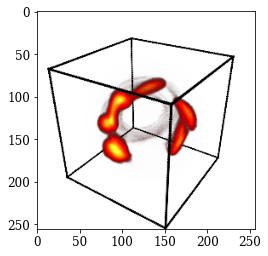

In [8]:
plt.figure()
plt.imshow(np.clip(rendering, 0.0, 1.0))
# plt.imsave('figures/nerf_vs_grid_1_spot_grid.pdf', np.clip(rendering, 0.0, 1.0))
# plt.imsave('figures/nerf_vs_grid_4_spots_grid.pdf', np.clip(rendering, 0.0, 1.0))
plt.imsave('figures/nerf_vs_grid_4+4_spots_grid.pdf', np.clip(rendering, 0.0, 1.0))

In [9]:
# Visualize Network Emission

t_vis = t * jnp.ones_like(x_vis)

hparams = {
    'num_iters': 5000,
    'lr_init': 1e-4,
    'lr_final': 1e-6,
    'lr_axis': 1e-2,
    'posenc_deg': 3,
    'batchsize': 8,
    'r_min': r_min,
    'r_max': r_max,
}

# runname = 'nerf_vs_grid_11_1_21/network_1_spot'
# runname = 'nerf_vs_grid_11_1_21/network_4_spots'
runname = 'nerf_vs_grid_11_1_21/network_fancy_4+4_spots'

# Model setup and initialization

rng = jax.random.PRNGKey(1)

predictor = network_utils.PREDICT_EMISSION_3D()
params = predictor.init(rng, x_vis[0, :1, ...], y_vis[0, :1, ...], z_vis[0, :1, ...], t_vis[0, :1, ...], velocity_field, rot_axis)['params']
tx = optax.adam(learning_rate=optax.polynomial_schedule(hparams['lr_init'], hparams['lr_final'], 1, hparams['num_iters']))
state = train_state.TrainState.create(apply_fn=predictor.apply, params=params.unfreeze(), tx=tx)  # TODO(pratul): this unfreeze feels sketchy

checkpoint_dir = 'checkpoints/{}'.format(runname)
state = checkpoints.restore_checkpoint(checkpoint_dir, state)

eval_pstep = jax.pmap(predictor.eval_step, axis_name='batch', in_axes=(None, None, None, 0, 0, 0, 0, 0, 0, 0, 0), static_broadcasted_argnums=(0))

state = flax.jax_utils.replicate(state)

rand_key = jax.random.split(rng, jax.local_device_count())

chunk = 64

emission_list = []
for c in range(y_res_vis//chunk):
    x_chunk = x_vis[:, c * chunk : (c + 1) * chunk, :, :]
    y_chunk = y_vis[:, c * chunk : (c + 1) * chunk, :, :]
    z_chunk = z_vis[:, c * chunk : (c + 1) * chunk, :, :]
    d_chunk = d_vis[:, c * chunk : (c + 1) * chunk, :, :]
    t_chunk = t_vis[:, c * chunk : (c + 1) * chunk, :, :]

    _, _, emission_vis_chunk, _, _ = eval_pstep(velocity_field, rot_axis, i, shard(x_chunk), shard(y_chunk), shard(z_chunk), 
                                          shard(d_chunk), shard(t_chunk), shard(jnp.zeros_like(x_chunk[..., 0])), state, rand_key)

    emission_list.append(emission_vis_chunk)

emission_vis = np.concatenate(emission_list, axis=1)
                              
emission_vis = np.reshape(emission_vis, [1, x_res_vis, y_res_vis, z_res_vis])
emission_vis = jnp.where(x_vis**2 + y_vis**2 + z_vis**2 < r_min**2, jnp.zeros_like(emission_vis), emission_vis)
emission_vis = jnp.where(x_vis**2 + y_vis**2 + z_vis**2 > r_max**2, jnp.zeros_like(emission_vis), emission_vis)

emission_vis = emission_vis[0, ...]

# scale for visualization
emission_vis *= 1.

cm = plt.get_cmap('hot')
emission_cm = cm(emission_vis)
emission_cm = jnp.clip(emission_cm - 0.05, 0.0, 1.0)
emission_cm = jnp.concatenate([emission_cm[..., :3], (emission_vis[..., None] / jnp.amax(emission_vis))], axis=-1)

emission_vis_cube = draw_cube(emission_cm, jnp.stack([x_vis[0], y_vis[0], z_vis[0]], axis=-1))

rendering, _ = alpha_composite(emission_vis_cube, d_vis, pts[0, ...])

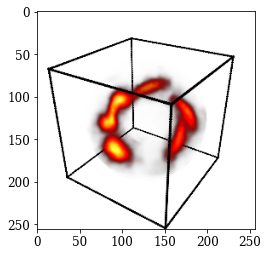

In [10]:
plt.figure()
plt.imshow(np.clip(rendering, 0.0, 1.0))
# plt.imsave('figures/nerf_vs_grid_1_spot_network.pdf', np.clip(rendering, 0.0, 1.0))
# plt.imsave('figures/nerf_vs_grid_4_spots_network.pdf', np.clip(rendering, 0.0, 1.0))
plt.imsave('figures/nerf_vs_grid_4+4_spots_network.pdf', np.clip(rendering, 0.0, 1.0))

In [23]:
# Visualize 4D Network Emission

t_vis = t * jnp.ones_like(x_vis)

hparams = {
    'num_iters': 5000,
    'lr_init': 1e-4,
    'lr_final': 1e-6,
    'lr_axis': 1e-2,
    'posenc_deg': 3,
    'batchsize': 8,
    'r_min': r_min,
    'r_max': r_max,
}

# runname = 'nerf_vs_grid_11_3_21/network_4D_1_spot'
# runname = 'nerf_vs_grid_11_3_21/network_4D_4_spots'
runname = 'nerf_vs_grid_11_3_21/network_4D_fancy_4+4_spots'

# Model setup and initialization

rng = jax.random.PRNGKey(1)

predictor = network_utils.PREDICT_EMISSION_3D_NO_VELOCITY()
params = predictor.init(rng, x_vis[0, :1, ...], y_vis[0, :1, ...], z_vis[0, :1, ...], t_vis[0, :1, ...], velocity_field, rot_axis)['params']
tx = optax.adam(learning_rate=optax.polynomial_schedule(hparams['lr_init'], hparams['lr_final'], 1, hparams['num_iters']))
state = train_state.TrainState.create(apply_fn=predictor.apply, params=params.unfreeze(), tx=tx)  # TODO(pratul): this unfreeze feels sketchy

checkpoint_dir = 'checkpoints/{}'.format(runname)
state = checkpoints.restore_checkpoint(checkpoint_dir, state)

eval_pstep = jax.pmap(predictor.eval_step, axis_name='batch', in_axes=(None, None, None, 0, 0, 0, 0, 0, 0, 0, 0), static_broadcasted_argnums=(0))

state = flax.jax_utils.replicate(state)

rand_key = jax.random.split(rng, jax.local_device_count())

chunk = 64

emission_list = []
for c in range(y_res_vis//chunk):
    x_chunk = x_vis[:, c * chunk : (c + 1) * chunk, :, :]
    y_chunk = y_vis[:, c * chunk : (c + 1) * chunk, :, :]
    z_chunk = z_vis[:, c * chunk : (c + 1) * chunk, :, :]
    d_chunk = d_vis[:, c * chunk : (c + 1) * chunk, :, :]
    t_chunk = t_vis[:, c * chunk : (c + 1) * chunk, :, :]

    _, _, emission_vis_chunk, _, _ = eval_pstep(velocity_field, rot_axis, i, shard(x_chunk), shard(y_chunk), shard(z_chunk), 
                                          shard(d_chunk), shard(t_chunk), shard(jnp.zeros_like(x_chunk[..., 0])), state, rand_key)

    emission_list.append(emission_vis_chunk)

emission_vis = np.concatenate(emission_list, axis=1)
                              
emission_vis = np.reshape(emission_vis, [1, x_res_vis, y_res_vis, z_res_vis])
emission_vis = jnp.where(x_vis**2 + y_vis**2 + z_vis**2 < r_min**2, jnp.zeros_like(emission_vis), emission_vis)
emission_vis = jnp.where(x_vis**2 + y_vis**2 + z_vis**2 > r_max**2, jnp.zeros_like(emission_vis), emission_vis)

emission_vis = emission_vis[0, ...]

# scale for visualization
emission_vis *= 1.

cm = plt.get_cmap('hot')
emission_cm = cm(emission_vis)
emission_cm = jnp.clip(emission_cm - 0.05, 0.0, 1.0)
emission_cm = jnp.concatenate([emission_cm[..., :3], (emission_vis[..., None] / jnp.amax(emission_vis))], axis=-1)

emission_vis_cube = draw_cube(emission_cm, jnp.stack([x_vis[0], y_vis[0], z_vis[0]], axis=-1))

rendering, _ = alpha_composite(emission_vis_cube, d_vis, pts[0, ...])

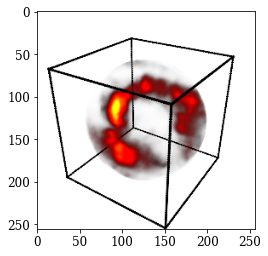

In [24]:
plt.figure()
plt.imshow(np.clip(rendering, 0.0, 1.0))
# plt.imsave('figures/nerf_vs_grid_1_spot_4Dnetwork.pdf', np.clip(rendering, 0.0, 1.0))
# plt.imsave('figures/nerf_vs_grid_4_spots_4Dnetwork.pdf', np.clip(rendering, 0.0, 1.0))
plt.imsave('figures/nerf_vs_grid_4+4_spots_4Dnetwork.pdf', np.clip(rendering, 0.0, 1.0))

In [43]:
print(np.amax(emission_vis))
emission_cm = cm(emission_vis/np.amax(emission_vis))
print(np.amax(emission_cm[..., :3]))

0.009391978
1.0


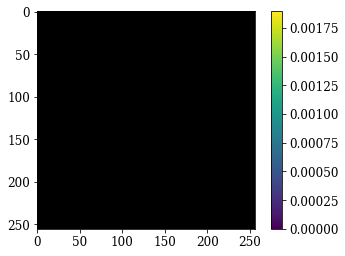

In [37]:
plt.figure()
plt.imshow(emission_cm[:,:,128,:3])
plt.colorbar()

In [17]:
print(emission_cm)

[[[[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  ...

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]]


 [[[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0